<a href="https://colab.research.google.com/github/Divyascientist/KNN-ALABS/blob/main/weather_prediction_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot  as plt
from pylab import rcParams

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

from torch import nn,optim
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid',palette='muted',font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

RANDOM_SEED=42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)



In [ ]:


from google.colab import files
uploaded = files.upload()







Saving weatherAUS.csv to weatherAUS.csv


In [ ]:
import io
df = pd.read_csv('weatherAUS.csv')


In [ ]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [ ]:
df.shape

(145460, 23)

In [ ]:
cols = ['Rainfall', 'Humidity3pm', 'Pressure9am', 'RainToday', 'RainTomorrow']

df = df[cols]

In [ ]:
df.RainToday.replace( {'No': 0, 'Yes': 1}, inplace=True)
df.RainTomorrow.replace( {'No': 0, 'Yes': 1}, inplace=True)

<ipython-input-9-9bb6741f5dca>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.RainToday.replace( {'No': 0, 'Yes': 1}, inplace=True)
<ipython-input-9-9bb6741f5dca>:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.RainToday.replace( {'No': 0, 'Yes': 1}, inplace=True)
<ipython-input-9-9bb6741f5

In [ ]:
df.dropna(how='any', inplace=True)
df.head()

,Rainfall,Humidity3pm,Pressure9am,RainToday,RainTomorrow
0,0.6,22.0,1007.7,0.0,0.0
1,0.0,25.0,1010.6,0.0,0.0
2,0.0,30.0,1007.6,0.0,0.0
3,0.0,16.0,1017.6,0.0,0.0
4,1.0,33.0,1010.8,0.0,0.0


In [ ]:
df.RainTomorrow.value_counts()/df.shape[0]

,count
RainTomorrow,
0.0,0.778762
1.0,0.221238


Things are not looking good. About 78% of the data points have a non-rainy day for tomorrow. This means that a model that predicts there will be no rain tomorrow will be correct about 78% of the time.

Here, we'll keep things simple and proceed

In [ ]:
X = df[['Rainfall', 'Humidity3pm', 'RainToday', 'Pressure9am']]
y = df[['RainTomorrow']]

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=RANDOM_SEED)



In [ ]:
y_train=torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())


AttributeError: 'Tensor' object has no attribute 'to_numpy'

In [ ]:
x_train=torch.from_numpy(X_train.to_numpy()).float()

In [ ]:
x_test=torch.from_numpy(X_test.to_numpy()).float()
y_test=torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

AttributeError: 'Tensor' object has no attribute 'to_numpy'

In [ ]:
class Net(nn.Module):
  def __init__(self,n_features):
    super(Net,self).__init__()
    self.fc1=nn.Linear(n_features,5)
    self.fc2=nn.Linear(5,3)
    self.fc3=nn.Linear(3,1)
  def forward(self,x):
    x=F.relu(self.fc1(x))
    x=F.relu(self.fc2(x))
    x=torch.sigmoid(self.fc3(x))
    return x

In [ ]:
def ann_viz(model, view=True, filename="network.gv"):
    """Vizualizez a Sequential model.

    # Arguments
        model: A Keras model instance.

        view: whether to display the model after generation.

        filename: where to save the vizualization. (a .gv file)

        title: A title for the graph
    """
    from graphviz import Digraph

    input_layer = 0
    hidden_layers_nr = 0
    layer_types = []
    hidden_layers = []
    output_layer = 0
    layers = [layer for layer in model.modules() if type(layer) == torch.nn.Linear]

    for layer in layers:
        if layer == layers[0]:
            input_layer = layer.in_features
            hidden_layers_nr += 1
            if type(layer) == torch.nn.Linear:
                hidden_layers.append(layer.out_features)
                layer_types.append("Dense")
            else:
                raise Exception("Input error")
        else:
            if layer == layers[-1]:
                output_layer = layer.out_features
            else:
                hidden_layers_nr += 1
                if type(layer) == torch.nn.Linear:

                    hidden_layers.append(layer.out_features)
                    layer_types.append("Dense")
                else:
                    raise Exception("Hidden error")
        last_layer_nodes = input_layer
        nodes_up = input_layer

    g = Digraph("g", filename=filename)
    n = 0
    g.graph_attr.update(splines="false", nodesep="0.5", ranksep="0", rankdir='LR')
    # Input Layer
    with g.subgraph(name="cluster_input") as c:
        if type(layers[0]) == torch.nn.Linear:
            the_label = "Input Layer"
            if layers[0].in_features > 10:
                the_label += " (+" + str(layers[0].in_features - 10) + ")"
                input_layer = 10
            c.attr(color="white")
            for i in range(0, input_layer):
                n += 1
                c.node(str(n))
                c.attr(labeljust="1")
                c.attr(label=the_label, labelloc="bottom")
                c.attr(rank="same")
                c.node_attr.update(
                    width="0.65",
                    style="filled",
                    shape="circle",
                    color=HAPPY_COLORS_PALETTE[3],
                    fontcolor=HAPPY_COLORS_PALETTE[3],
                )
    for i in range(0, hidden_layers_nr):
        with g.subgraph(name="cluster_" + str(i + 1)) as c:
            if layer_types[i] == "Dense":
                c.attr(color="white")
                c.attr(rank="same")
                the_label = f'Hidden Layer {i + 1}'
                if layers[i].out_features > 10:
                    the_label += " (+" + str(layers[i].out_features - 10) + ")"
                    hidden_layers[i] = 10
                c.attr(labeljust="right", labelloc="b", label=the_label)
                for j in range(0, hidden_layers[i]):
                    n += 1
                    c.node(
                        str(n),
                        width="0.65",
                        shape="circle",
                        style="filled",
                        color=HAPPY_COLORS_PALETTE[0],
                        fontcolor=HAPPY_COLORS_PALETTE[0],
                    )
                    for h in range(nodes_up - last_layer_nodes + 1, nodes_up + 1):
                        g.edge(str(h), str(n))
                last_layer_nodes = hidden_layers[i]
                nodes_up += hidden_layers[i]
            else:
                raise Exception("Hidden layer type not supported")

    with g.subgraph(name="cluster_output") as c:
        if type(layers[-1]) == torch.nn.Linear:
            c.attr(color="white")
            c.attr(rank="same")
            c.attr(labeljust="1")
            for i in range(1, output_layer + 1):
                n += 1
                c.node(
                    str(n),
                    width="0.65",
                    shape="circle",
                    style="filled",
                    color=HAPPY_COLORS_PALETTE[4],
                    fontcolor=HAPPY_COLORS_PALETTE[4],

                )
                for h in range(nodes_up - last_layer_nodes + 1, nodes_up + 1):
                    g.edge(str(h), str(n))
            c.attr(label="Output Layer", labelloc="bottom")
            c.node_attr.update(
                color="#2ecc71", style="filled", fontcolor="#2ecc71", shape="circle"
            )

    g.attr(arrowShape="none")
    g.edge_attr.update(arrowhead="none", color="#707070", penwidth="2")
    if view is True:
        g.view()

    return g


In [ ]:
net=Net(X_train.shape[1])

In [ ]:
net

Net(
  (fc1): Linear(in_features=4, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=3, bias=True)
  (fc3): Linear(in_features=3, out_features=1, bias=True)
)

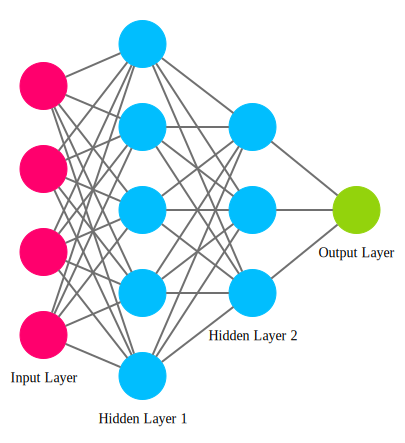

In [ ]:
ann_viz(net, view=False)

In [ ]:
criterion = nn.BCELoss()

In [ ]:
optimizer=optim.Adam(net.parameters(),lr=0.001)

In [ ]:
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

In [ ]:
def round_tensor(t,decimal_places=3):
  return round(t.item(),decimal_places)

In [ ]:
net(X_train)

TypeError: linear(): argument 'input' (position 1) must be Tensor, not DataFrame

In [ ]:
for epoch in range(1000):

   y_pred = net(x_train)

   y_pred=torch.squeeze(y_pred)
   train_loss=criterion(y_pred,y_train)

   if epoch % 100 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)

      y_test_pred = net(x_test)
      y_test_pred = torch.squeeze(y_test_pred)

      test_loss = criterion(y_test_pred, y_test)

      test_acc = calculate_accuracy(y_test, y_test_pred)
      print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')

      optimizer.zero_grad()

      train_loss.backward()

      optimizer.step()


epoch 0
Train set - loss: 2.513, accuracy: 0.779
Test  set - loss: 2.517, accuracy: 0.778

epoch 100
Train set - loss: 2.265, accuracy: 0.779
Test  set - loss: 2.269, accuracy: 0.778

epoch 200
Train set - loss: 2.017, accuracy: 0.779
Test  set - loss: 2.02, accuracy: 0.778

epoch 300
Train set - loss: 1.768, accuracy: 0.779
Test  set - loss: 1.77, accuracy: 0.779

epoch 400
Train set - loss: 1.519, accuracy: 0.779
Test  set - loss: 1.521, accuracy: 0.778

epoch 500
Train set - loss: 1.27, accuracy: 0.779
Test  set - loss: 1.272, accuracy: 0.778

epoch 600
Train set - loss: 1.025, accuracy: 0.78
Test  set - loss: 1.027, accuracy: 0.779

epoch 700
Train set - loss: 0.792, accuracy: 0.78
Test  set - loss: 0.794, accuracy: 0.78

epoch 800
Train set - loss: 0.594, accuracy: 0.782
Test  set - loss: 0.596, accuracy: 0.781

epoch 900
Train set - loss: 0.484, accuracy: 0.787
Test  set - loss: 0.486, accuracy: 0.787



In [ ]:
classes = ['No rain', 'Raining']

y_pred = net(x_test)

y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()

print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

     No rain       0.81      0.96      0.88     19413
     Raining       0.62      0.22      0.33      5525

    accuracy                           0.80     24938
   macro avg       0.71      0.59      0.60     24938
weighted avg       0.77      0.80      0.76     24938

